# Football Data Engineering avec PySpark : Statistiques, KPIs et champions ⚽

# Étape 1 : Chargement et préparation des données

## Charger le fichier CSV dans un DataFrame PySpark.

1 Installer et importer PySpark (nécessaire dans Google Colab)

In [6]:
!pip install pyspark

2 Initialiser une session Spark

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType

spark = SparkSession.builder \
    .appName("FootballPerformanceAnalysis") \
    .getOrCreate()

3️ Définir le schéma du fichier CSV

In [8]:
schema = StructType([
    StructField("Match_ID", IntegerType(), True),
    StructField("Div", StringType(), True),
    StructField("Season", IntegerType(), True),
    StructField("Date", StringType(), True),
    StructField("HomeTeam", StringType(), True),
    StructField("AwayTeam", StringType(), True),
    StructField("FTHG", IntegerType(), True),  # Full Time Home Goals
    StructField("FTAG", IntegerType(), True),  # Full Time Away Goals
    StructField("FTR", StringType(), True)     # Full Time Result (H/A/D)
])

4️ Charger le fichier CSV dans un DataFrame PySpark

In [10]:
file_path = "/content/football-matches-68e30d7701b83243515688.csv"

df_raw = spark.read.csv(file_path, header=True, schema=schema)

5️ Aperçu des données

In [11]:
print(" Aperçu du dataset brut :")
df_raw.show(5)
print("Nombre total de lignes :", df_raw.count())

 Aperçu du dataset brut :
+--------+---+------+----------+-------------+--------------+----+----+---+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+--------+---+------+----------+-------------+--------------+----+----+---+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|   2|   1|  H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|   0|   1|  A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|   1|   1|  D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|   2|   1|  H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|   1|   3|  A|
+--------+---+------+----------+-------------+--------------+----+----+---+
only showing top 5 rows

Nombre total de lignes : 24625


## Comprendre la signification des colonnes.

In [12]:
# ----------------------------------------------------------
# Comprendre la signification et les types de colonnes
# ----------------------------------------------------------
print("📋 Schéma du DataFrame :")
df_raw.printSchema()

print("🧠 Description statistique :")
df_raw.describe(["FTHG", "FTAG"]).show()

📋 Schéma du DataFrame :
root
 |-- Match_ID: integer (nullable = true)
 |-- Div: string (nullable = true)
 |-- Season: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- FTHG: integer (nullable = true)
 |-- FTAG: integer (nullable = true)
 |-- FTR: string (nullable = true)

🧠 Description statistique :
+-------+------------------+------------------+
|summary|              FTHG|              FTAG|
+-------+------------------+------------------+
|  count|             24625|             24625|
|   mean|1.5170355329949239| 1.097502538071066|
| stddev|1.3594706607115317|1.1635103573988272|
|    min|                -1|                -1|
|    max|                 9|                 9|
+-------+------------------+------------------+



## Renommer et supprimer des colonnes inutiles.

In [13]:
# ----------------------------------------------------------
# 1 Renommer et supprimer les colonnes inutiles
# ----------------------------------------------------------

df_cleaned = df_raw.selectExpr(
    "*",
    "FTHG as HomeTeamGoals",
    "FTAG as AwayTeamGoals",
    "FTR as FinalResult"
)


In [ ]:
df_cleaned.show(5)

+--------+---+------+----------+-------------+--------------+----+----+---+-------------+-------------+-----------+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|FTHG|FTAG|FTR|HomeTeamGoals|AwayTeamGoals|FinalResult|
+--------+---+------+----------+-------------+--------------+----+----+---+-------------+-------------+-----------+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|   2|   1|  H|            2|            1|          H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|   0|   1|  A|            0|            1|          A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|   1|   1|  D|            1|            1|          D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|   2|   1|  H|            2|            1|          H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|   1|   3|  A|            1|            3|          A|
+--------+---+------+----------+-------------+--------------+----+----+-

In [14]:
df_cleaned = df_cleaned.drop("Date","FTHG", "FTAG","FTR")

In [15]:
df_cleaned.show(5)

+--------+---+------+-------------+--------------+-------------+-------------+-----------+
|Match_ID|Div|Season|     HomeTeam|      AwayTeam|HomeTeamGoals|AwayTeamGoals|FinalResult|
+--------+---+------+-------------+--------------+-------------+-------------+-----------+
|       1| D2|  2009|   Oberhausen|Kaiserslautern|            2|            1|          H|
|       2| D2|  2009|  Munich 1860|Kaiserslautern|            0|            1|          A|
|       3| D2|  2009|Frankfurt FSV|Kaiserslautern|            1|            1|          D|
|       4| D2|  2009|Frankfurt FSV|     Karlsruhe|            2|            1|          H|
|       5| D2|  2009|        Ahlen|     Karlsruhe|            1|            3|          A|
+--------+---+------+-------------+--------------+-------------+-------------+-----------+
only showing top 5 rows



In [16]:
# ----------------------------------------------------------
# 2 Vérification du DataFrame nettoyé
# ----------------------------------------------------------

print(" Schéma après renommage :")
df_cleaned.printSchema()

print(" Exemple de données transformées :")
df_cleaned.show(5)

 Schéma après renommage :
root
 |-- Match_ID: integer (nullable = true)
 |-- Div: string (nullable = true)
 |-- Season: integer (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- HomeTeamGoals: integer (nullable = true)
 |-- AwayTeamGoals: integer (nullable = true)
 |-- FinalResult: string (nullable = true)

 Exemple de données transformées :
+--------+---+------+-------------+--------------+-------------+-------------+-----------+
|Match_ID|Div|Season|     HomeTeam|      AwayTeam|HomeTeamGoals|AwayTeamGoals|FinalResult|
+--------+---+------+-------------+--------------+-------------+-------------+-----------+
|       1| D2|  2009|   Oberhausen|Kaiserslautern|            2|            1|          H|
|       2| D2|  2009|  Munich 1860|Kaiserslautern|            0|            1|          A|
|       3| D2|  2009|Frankfurt FSV|Kaiserslautern|            1|            1|          D|
|       4| D2|  2009|Frankfurt FSV|     Karlsruhe|       

# Étape 2: Création de colonnes supplémentaires

## Colonnes indicatrices : HomeTeamWin, AwayTeamWin, GameTie.

In [17]:
import pyspark.sql.functions as F
from pyspark.sql.functions import when, col

df_cleaned = (
    df_cleaned.withColumn("HomeTeamWin", when(col("FinalResult") == "H", 1).otherwise(0))
      .withColumn("AwayTeamWin", when(col("FinalResult") == "A", 1).otherwise(0))
      .withColumn("GameTie", when(col("FinalResult") == "D", 1).otherwise(0))
)

## Vérification des résultats

In [18]:
# Afficher un aperçu du DataFrame
df_cleaned.show(10, truncate=False)

# Vérifier la distribution des résultats
df_cleaned.groupBy("FinalResult").count().show()

# Vérifier la cohérence des colonnes indicatrices
df_cleaned.select("FinalResult", "HomeTeamWin", "AwayTeamWin", "GameTie").distinct().show()

+--------+---+------+--------------+--------------+-------------+-------------+-----------+-----------+-----------+-------+
|Match_ID|Div|Season|HomeTeam      |AwayTeam      |HomeTeamGoals|AwayTeamGoals|FinalResult|HomeTeamWin|AwayTeamWin|GameTie|
+--------+---+------+--------------+--------------+-------------+-------------+-----------+-----------+-----------+-------+
|1       |D2 |2009  |Oberhausen    |Kaiserslautern|2            |1            |H          |1          |0          |0      |
|2       |D2 |2009  |Munich 1860   |Kaiserslautern|0            |1            |A          |0          |1          |0      |
|3       |D2 |2009  |Frankfurt FSV |Kaiserslautern|1            |1            |D          |0          |0          |1      |
|4       |D2 |2009  |Frankfurt FSV |Karlsruhe     |2            |1            |H          |1          |0          |0      |
|5       |D2 |2009  |Ahlen         |Karlsruhe     |1            |3            |A          |0          |1          |0      |
|6      

# Étape 3: Filtrage des données

## 1. Garder uniquement la Bundesliga (Div = D1).

In [19]:
from pyspark.sql.functions import col

In [20]:
# ==============================
# Filtrage : Bundesliga uniquement
# ==============================
df_filtered = df_cleaned.filter(col("Div") == "D1")

## 2. Restreindre aux saisons 2000–2015.

In [21]:
# ==============================
# Filtrage : saisons entre 2000 et 2015 inclus
# ==============================
df_filtered = df_filtered.filter((col("Season") >= 2000) & (col("Season") <= 2015))

In [22]:
# ==============================
# Vérification du filtrage
# ==============================
print("Nombre de lignes après filtrage :", df_filtered.count())
df_filtered.select("Season", "Div").distinct().orderBy("Season").show(20, truncate=False)

Nombre de lignes après filtrage : 4896
+------+---+
|Season|Div|
+------+---+
|2000  |D1 |
|2001  |D1 |
|2002  |D1 |
|2003  |D1 |
|2004  |D1 |
|2005  |D1 |
|2006  |D1 |
|2007  |D1 |
|2008  |D1 |
|2009  |D1 |
|2010  |D1 |
|2011  |D1 |
|2012  |D1 |
|2013  |D1 |
|2014  |D1 |
|2015  |D1 |
+------+---+



# Étape 4: Agrégations avec Group By (voir ressources)

In [23]:
from pyspark.sql import functions as F

# ==============================
# Agrégations pour les matchs à domicile
# ==============================
df_home_matches = (
    df_filtered.groupBy("Season", "HomeTeam")
    .agg(
        F.count("*").alias("HomeGamesPlayed"),
        F.sum("HomeTeamWin").alias("TotalHomeWin"),
        F.sum("AwayTeamWin").alias("TotalHomeLoss"),
        F.sum("GameTie").alias("TotalHomeTie"),
        F.sum("HomeTeamGoals").alias("HomeScoredGoals"),
        F.sum("AwayTeamGoals").alias("HomeAgainstGoals"),
    )
    .withColumnRenamed("HomeTeam", "Team")
)

# ==============================
# Agrégations pour les matchs à l’extérieur
# ==============================
df_away_matches = (
    df_filtered.groupBy("Season", "AwayTeam")
    .agg(
        F.count("*").alias("AwayGamesPlayed"),
        F.sum("AwayTeamWin").alias("TotalAwayWin"),
        F.sum("HomeTeamWin").alias("TotalAwayLoss"),
        F.sum("GameTie").alias("TotalAwayTie"),
        F.sum("AwayTeamGoals").alias("AwayScoredGoals"),
        F.sum("HomeTeamGoals").alias("AwayAgainstGoals"),
    )
    .withColumnRenamed("AwayTeam", "Team")
)

# ==============================
# Vérification rapide
# ==============================
print("✅ Statistiques à domicile :")
df_home_matches.show(5, truncate=False)

print("✅ Statistiques à l’extérieur :")
df_away_matches.show(5, truncate=False)


✅ Statistiques à domicile :
+------+-------------+---------------+------------+-------------+------------+---------------+----------------+
|Season|Team         |HomeGamesPlayed|TotalHomeWin|TotalHomeLoss|TotalHomeTie|HomeScoredGoals|HomeAgainstGoals|
+------+-------------+---------------+------------+-------------+------------+---------------+----------------+
|2005  |Bayern Munich|17             |14          |1            |2           |42             |14              |
|2008  |M'gladbach   |17             |5           |8            |4           |23             |27              |
|2014  |Freiburg     |17             |5           |6            |6           |21             |22              |
|2015  |Wolfsburg    |17             |9           |3            |5           |32             |17              |
|2006  |Cottbus      |17             |6           |6            |5           |21             |22              |
+------+-------------+---------------+------------+-------------+-----------

# Étape 5. Jointure de DataFrames

## Fusionner df_home_matches et df_away_matches ----> df_merged

In [24]:
from pyspark.sql import functions as F

# ==============================
# Jointure entre les stats domicile et extérieur
# ==============================
df_merged = df_home_matches.join(
    df_away_matches,
    on=["Season", "Team"],
    how="inner"
)

# ==============================
# Création des colonnes totales combinées
# ==============================
df_merged = (
    df_merged.withColumn("TotalGames", F.col("HomeGamesPlayed") + F.col("AwayGamesPlayed"))
    .withColumn("Win", F.col("TotalHomeWin") + F.col("TotalAwayWin"))
    .withColumn("Loss", F.col("TotalHomeLoss") + F.col("TotalAwayLoss"))
    .withColumn("Tie", F.col("TotalHomeTie") + F.col("TotalAwayTie"))
    .withColumn("GoalsScored", F.col("HomeScoredGoals") + F.col("AwayScoredGoals"))
    .withColumn("GoalsAgainst", F.col("HomeAgainstGoals") + F.col("AwayAgainstGoals"))
)

# ==============================
# Vérification du DataFrame fusionné
# ==============================
print(" DataFrame fusionné : df_merged")
df_merged.select(
    "Season", "Team", "TotalGames", "Win", "Loss", "Tie", "GoalsScored", "GoalsAgainst"
).show(10, truncate=False)


 DataFrame fusionné : df_merged
+------+-------------+----------+---+----+---+-----------+------------+
|Season|Team         |TotalGames|Win|Loss|Tie|GoalsScored|GoalsAgainst|
+------+-------------+----------+---+----+---+-----------+------------+
|2005  |Bayern Munich|34        |22 |3   |9  |67         |32          |
|2008  |M'gladbach   |34        |8  |19  |7  |39         |62          |
|2014  |Freiburg     |34        |7  |14  |13 |36         |47          |
|2015  |Wolfsburg    |34        |12 |13  |9  |47         |49          |
|2006  |Cottbus      |34        |11 |15  |8  |38         |49          |
|2015  |Ein Frankfurt|34        |9  |16  |9  |34         |52          |
|2010  |Hannover     |34        |19 |12  |3  |49         |45          |
|2004  |Leverkusen   |34        |16 |9   |9  |65         |44          |
|2007  |Cottbus      |34        |9  |16  |9  |35         |56          |
|2011  |Werder Bremen|34        |11 |14  |9  |49         |58          |
+------+-------------+----------

# Étape 6. Création de nouvelles colonnes synthétiques


1. Colonnes totales : GoalsScored, GoalsAgainst, Win, Loss, Tie.
2. Colonnes avancées : GoalDifferentials, WinPercentage, GoalsPerGame, GoalsAgainstPerGame.


In [25]:
from pyspark.sql import functions as F

# ==============================
# Création des colonnes synthétiques
# ==============================
df_processed = (
    df_merged
    .withColumn("GoalDifferentials", F.col("GoalsScored") - F.col("GoalsAgainst"))
    .withColumn("WinPercentage", F.round((F.col("Win") / F.col("TotalGames")) * 100, 2))
    .withColumn("GoalsPerGame", F.round(F.col("GoalsScored") / F.col("TotalGames"), 2))
    .withColumn("GoalsAgainstPerGame", F.round(F.col("GoalsAgainst") / F.col("TotalGames"), 2))
)

# ==============================
# Vérification du résultat
# ==============================
print("✅ DataFrame après création des colonnes synthétiques : df_processed")
df_processed.select(
    "Season", "Team", "TotalGames", "Win", "Loss", "Tie",
    "GoalsScored", "GoalsAgainst", "GoalDifferentials",
    "WinPercentage", "GoalsPerGame", "GoalsAgainstPerGame"
).show(10, truncate=False)


✅ DataFrame après création des colonnes synthétiques : df_processed
+------+-------------+----------+---+----+---+-----------+------------+-----------------+-------------+------------+-------------------+
|Season|Team         |TotalGames|Win|Loss|Tie|GoalsScored|GoalsAgainst|GoalDifferentials|WinPercentage|GoalsPerGame|GoalsAgainstPerGame|
+------+-------------+----------+---+----+---+-----------+------------+-----------------+-------------+------------+-------------------+
|2005  |Bayern Munich|34        |22 |3   |9  |67         |32          |35               |64.71        |1.97        |0.94               |
|2008  |M'gladbach   |34        |8  |19  |7  |39         |62          |-23              |23.53        |1.15        |1.82               |
|2014  |Freiburg     |34        |7  |14  |13 |36         |47          |-11              |20.59        |1.06        |1.38               |
|2015  |Wolfsburg    |34        |12 |13  |9  |47         |49          |-2               |35.29        |1.38   

# Étape 7. Classement avec Window Functions

## 1. Créer une fenêtre partitionnée par Season.

In [26]:
from pyspark.sql import Window
from pyspark.sql import functions as F

# ==============================
# Définition de la fenêtre de classement
# ==============================
windowSpec = Window.partitionBy("Season").orderBy(
    F.desc("WinPercentage"),
    F.desc("GoalDifferentials")
)

## 2. Ajouter TeamPosition selon WinPercentage et GoalDifferentials.

In [27]:
# ==============================
# Ajout du classement (TeamPosition)
# ==============================
df_ranked = df_processed.withColumn(
    "TeamPosition",
    F.row_number().over(windowSpec)
)

## 3. vérification

In [28]:
# ==============================
# Vérification du résultat
# ==============================
print(" Classement des équipes par saison : df_ranked")
df_ranked.select(
    "Season", "Team", "WinPercentage", "GoalDifferentials", "TeamPosition"
).orderBy("Season", "TeamPosition").show(25, truncate=False)

 Classement des équipes par saison : df_ranked
+------+--------------+-------------+-----------------+------------+
|Season|Team          |WinPercentage|GoalDifferentials|TeamPosition|
+------+--------------+-------------+-----------------+------------+
|2000  |Bayern Munich |55.88        |25               |1           |
|2000  |Schalke 04    |52.94        |30               |2           |
|2000  |Hertha        |52.94        |6                |3           |
|2000  |Leverkusen    |50.0         |14               |4           |
|2000  |Dortmund      |47.06        |20               |5           |
|2000  |Freiburg      |44.12        |17               |6           |
|2000  |Werder Bremen |44.12        |5                |7           |
|2000  |Kaiserslautern|44.12        |-5               |8           |
|2000  |Wolfsburg     |35.29        |15               |9           |
|2000  |FC Koln       |35.29        |7                |10          |
|2000  |Munich 1860   |35.29        |-12              |1

# Étape 8. Extraction des champions & sauvegarde Parquet

## 1. Filtrer TeamPosition = 1.

In [29]:
from pyspark.sql import functions as F

# ==============================
# 1 Extraction des champions
# ==============================
df_top_teams = df_ranked.filter(F.col("TeamPosition") == 1)

# Vérification rapide
print("🏆 Champions par saison :")
df_top_teams.select("Season", "Team", "WinPercentage", "GoalDifferentials").orderBy("Season").show(20, truncate=False)

🏆 Champions par saison :
+------+-------------+-------------+-----------------+
|Season|Team         |WinPercentage|GoalDifferentials|
+------+-------------+-------------+-----------------+
|2000  |Bayern Munich|55.88        |25               |
|2001  |Leverkusen   |61.76        |39               |
|2002  |Bayern Munich|67.65        |45               |
|2003  |Werder Bremen|64.71        |41               |
|2004  |Bayern Munich|70.59        |42               |
|2005  |Bayern Munich|64.71        |35               |
|2006  |Stuttgart    |61.76        |24               |
|2007  |Bayern Munich|64.71        |47               |
|2008  |Wolfsburg    |61.76        |39               |
|2009  |Bayern Munich|58.82        |41               |
|2010  |Dortmund     |67.65        |45               |
|2011  |Dortmund     |73.53        |55               |
|2012  |Bayern Munich|85.29        |80               |
|2013  |Bayern Munich|85.29        |71               |
|2014  |Bayern Munich|73.53        |62  

## 2. Sauvegarder deux datasets au format Parquet :

In [30]:
# ==============================
# 2️ Sauvegarde au format Parquet
# ==============================

# Chemins de sortie (adaptés à Google Colab)
path_all_teams = "/content/football_stats_partitioned"
path_top_teams = "/content/football_top_teams"

# Sauvegarde du DataFrame complet (partitionné par saison)
df_ranked.write.mode("overwrite").partitionBy("Season").parquet(path_all_teams)

# Sauvegarde du DataFrame des champions
df_top_teams.write.mode("overwrite").parquet(path_top_teams)

print("✅ Données sauvegardées avec succès !")
print(f"📂 Toutes les équipes : {path_all_teams}")
print(f"🏅 Champions uniquement : {path_top_teams}")

✅ Données sauvegardées avec succès !
📂 Toutes les équipes : /content/football_stats_partitioned
🏅 Champions uniquement : /content/football_top_teams


# Étape 9. Visualisation

## 1. Convertir les champions en Pandas.

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 1️ Conversion du DataFrame Spark en Pandas
# ==============================
df_top_teams_pd = df_top_teams.select(
    "Season", "Team", "WinPercentage", "GoalsScored", "GoalDifferentials"
).toPandas()

# Trier par saison
df_top_teams_pd = df_top_teams_pd.sort_values(by="Season")

## 2. Réalisation des 3 graphiques :

1. % de victoires des champions.
2. Nombre de buts marqués.
3. GoalDifferentials par saison.

/tmp/ipython-input-3972762631.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_teams_pd, x="Season", y="WinPercentage", palette="viridis")


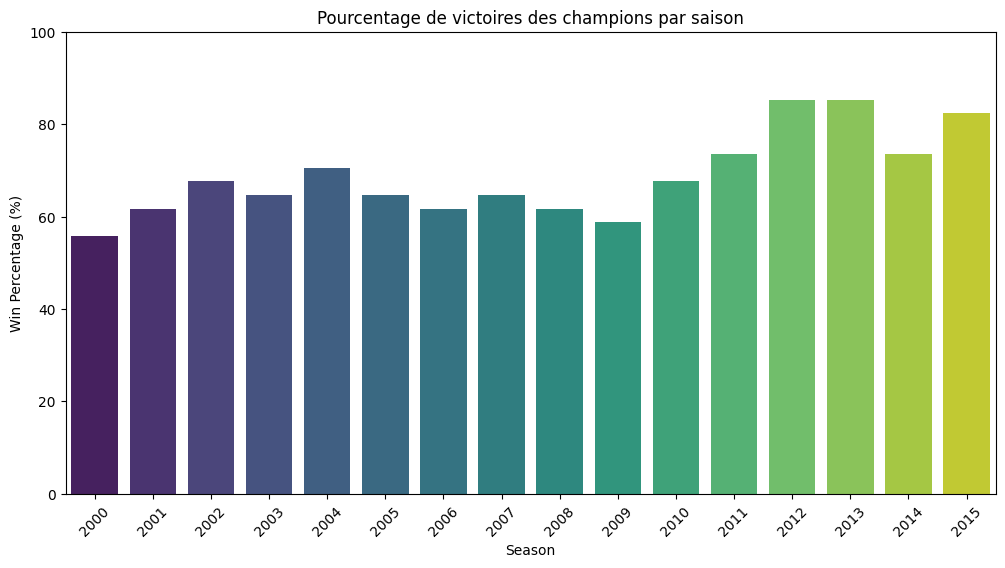

/tmp/ipython-input-3972762631.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_teams_pd, x="Season", y="GoalsScored", palette="magma")


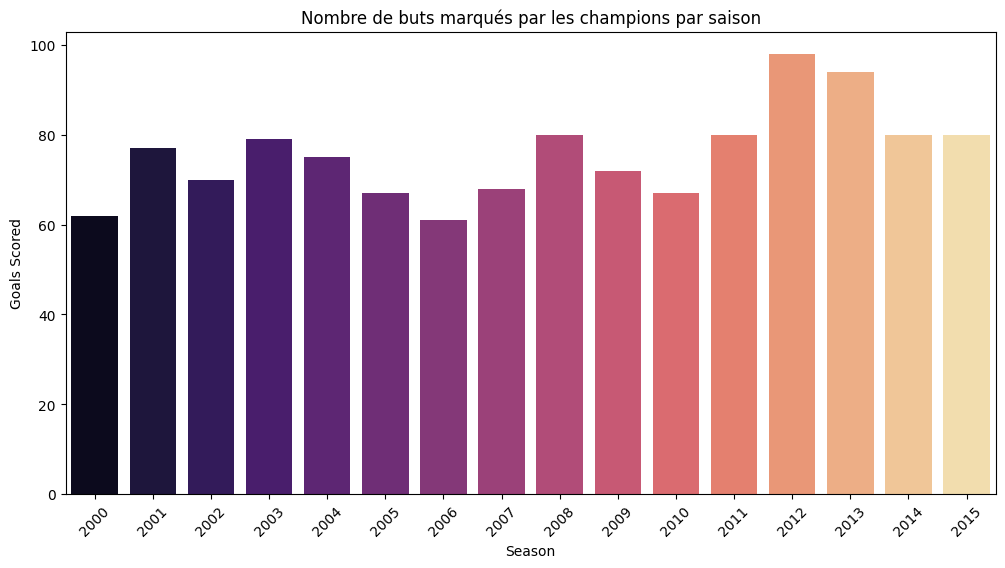

/tmp/ipython-input-3972762631.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_teams_pd, x="Season", y="GoalDifferentials", palette="coolwarm")


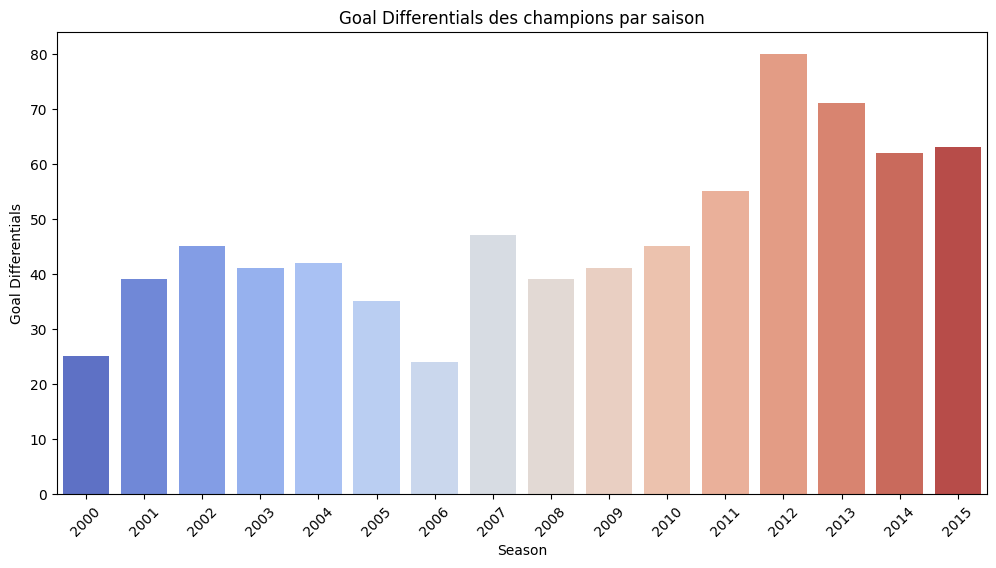

In [32]:
# ==============================
# 1 Graphique : % de victoires des champions
# ==============================
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_teams_pd, x="Season", y="WinPercentage", palette="viridis")
plt.title("Pourcentage de victoires des champions par saison")
plt.ylabel("Win Percentage (%)")
plt.xlabel("Season")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.show()

# ==============================
# 2 Graphique : Nombre de buts marqués
# ==============================
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_teams_pd, x="Season", y="GoalsScored", palette="magma")
plt.title("Nombre de buts marqués par les champions par saison")
plt.ylabel("Goals Scored")
plt.xlabel("Season")
plt.xticks(rotation=45)
plt.show()

# ==============================
# 3 Graphique : GoalDifferentials par saison
# ==============================
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_teams_pd, x="Season", y="GoalDifferentials", palette="coolwarm")
plt.title("Goal Differentials des champions par saison")
plt.ylabel("Goal Differentials")
plt.xlabel("Season")
plt.xticks(rotation=45)
plt.show()